Évaluation des résultats de lemmatisation 
==================================

## Objectifs

1. Lecture des logs
2. Alignement avec types de modèles
3. Lectures des résultats

## Data acquisition

In [21]:
import glob

# IMPORTANT: THIS IS HARD CODED, SUPPORT FOR ALL LEMMA FROM DEV SET

nb_words_dev_set = 19546


models = [
    
]
ModelScheme = {
    "config": "",
    "tar": "",
}
for file in glob.glob(
    "/home/thibault/dev/these/notebooks/1.4 - Lemmatisation/1.4.4 "
    "- Configuration de lemmatisation/Logs/*.log"):
    with open(file) as f:
        config = None
        current_task = None
        current = {
            "scores": {},
            "eval-time": []
        }
        for line in f:
            if line.startswith("config_path: "):
                current["config"] = line.strip()[len("config_path: "):]
            elif "Bye" in line.strip():
                models.append(current)
                current = {
                    "scores": {},
                    "eval-time": []
                }
                current_task = None
            elif line.startswith("#"):
                current_task = line.strip()[len("## "):]
                current["scores"][current_task] = {}
            elif current_task and line.startswith("|"):  # We already have a task recorded
                cat, acc, pre, rec, sup = [x.strip() for x in line.strip().split("|") if x]
                if sup == "support" or "---" in sup:
                    continue
                current["scores"][current_task][cat] = (float(acc), float(pre), float(rec), int(sup))
            elif ".tar" in line:
                current["file"] = line.strip()[len("Saved best model to: ["):-1]
            elif "Finished training in " in line:
                current["training-time"] = float(line.strip()[len("2020-04-23 23:13:33,251 : Finished training in ["):-1])
            elif "Starting epoch" in line:
                current["nb-epochs"] = int(line.strip()[len("2020-04-23 20:23:00,051 : Starting epoch ["):-1])
            elif "Evaluation time: " in line:
                current["eval-time"].append(
                    float(line.strip()[len("2020-04-24 04:04:56,425 : Evaluation time: "):-len(" sec")])
                )
                
models = {
    model["file"]: model for model in models
}

In [22]:
column = [
    "file", "conf",
    
    "acc", "acc-amb", "acc-unk-tar", "acc-unk-tok",
    "pos", "pos-amb", 
    "gend", "gend-amb", 
    
    "Unk-tar-support", "Unk-toks-support", "All support",
    
    "training-time", "nb-epochs", "Sec / Epoch",
    
    "Average Dev Test Time",
    "sec / 1000 words"
]

files = sorted(list(models.keys()))

table = []
for file in files:
    table.append([
        file,
        models[file]["config"],
        # Accuracies
        models[file]["scores"]["lemma"]["all"][0],
        models[file]["scores"]["lemma"]["ambiguous-tokens"][0],
        models[file]["scores"]["lemma"]["unknown-targets"][0],
        models[file]["scores"]["lemma"]["unknown-tokens"][0],
        # POS
        models[file]["scores"]["pos"]["all"][0],
        models[file]["scores"]["pos"]["ambiguous-tokens"][0],
        # POS
        models[file]["scores"]["Gend"]["all"][0],
        models[file]["scores"]["Gend"]["ambiguous-tokens"][0],
        # Supports
        models[file]["scores"]["lemma"]["unknown-targets"][-1],
        models[file]["scores"]["lemma"]["unknown-tokens"][-1],
        models[file]["scores"]["lemma"]["all"][-1],
        # Time
        models[file].get("training-time", 0),
        models[file]["nb-epochs"],
        round(models[file].get("training-time", 0) / models[file]["nb-epochs"], 2),
        # Inference time
        round(sum(models[file]["eval-time"][1:]) / len(models[file]["eval-time"][1:]), 2),
        round(
            nb_words_dev_set /
            (sum(models[file]["eval-time"][1:]) / len(models[file]["eval-time"][1:]))
            , 2
        )
        
    ])
    
table = sorted(table, key=lambda x: x[2])  # 2 is acc, 3 amb, 5 tokens
table = [column] + table

In [23]:
# Create a table like representation
import tabulate
from IPython.display import HTML, display

display(HTML(tabulate.tabulate(table, tablefmt='html')))

file,conf,acc,acc-amb,acc-unk-tar,acc-unk-tok,pos,pos-amb,gend,gend-amb,Unk-tar-support,Unk-toks-support,All support,training-time,nb-epochs,Sec / Epoch,Average Dev Test Time,sec / 1000 words
./models/cemb_CNN_-wemb_none_-lrpatience_4;7_-lemma-2020_04_24-00_37_47.tar,./configs/1.4.4.a-CNN_vs_RNN-CNN-nowemb.json,0.9555,0.8957,0.5019,0.7739,0.8972,0.8385,0.9163,0.7524,771,5773,172968,4929.73,27,182.58,7.12,2744.64
./models/cemb_CNN_-wemb_none_-lrpatience_4;7_-lemma-2020_04_24-11_24_15.tar,./configs/1.4.4.a-CNN_vs_RNN-CNN-nowemb.json,0.9601,0.8995,0.5201,0.8032,0.9234,0.8667,0.9286,0.7852,771,5773,172968,9192.01,50,183.84,7.12,2746.92
./models/cemb_CNN_-wemb_none_-lrpatience_4;7_-lemma-2020_04_24-23_42_23.tar,./configs/1.4.4.a-CNN_vs_RNN-CNN-nowemb.json,0.9611,0.9026,0.5292,0.8003,0.9274,0.8704,0.9267,0.7911,771,5773,172968,8025.91,44,182.41,7.12,2743.74
./models/cemb_RNN_-wemb_none_-lrpatience_5;7_-lemma-2020_04_24-05_39_38.tar,./configs/1.4.4.a-CNN_vs_RNN-RNN-nowemb.json,0.9619,0.8997,0.5837,0.8157,0.9582,0.894,0.9589,0.845,771,5773,172968,5071.46,22,230.52,7.73,2528.08
./models/cemb_CNN_-patience_5_-lemma-2020_04_23-00_52_52.tar,./configs/1.4.4.a-CNN_vs_RNN-CNN-patience.json,0.9627,0.9102,0.5629,0.8027,0.9511,0.8989,0.951,0.8425,771,5773,172968,7357.5,38,193.62,7.2,2713.18
./models/cemb_CNN_-patience_5_-lemma-2020_04_23-04_14_02.tar,./configs/1.4.4.a-CNN_vs_RNN-CNN-patience.json,0.9642,0.912,0.5162,0.8025,0.9496,0.8959,0.9494,0.8354,771,5773,172968,5945.53,31,191.79,7.15,2732.68
./models/cemb_RNN_-wemb_none_-lrpatience_5;7_-lemma-2020_04_24-17_11_30.tar,./configs/1.4.4.a-CNN_vs_RNN-RNN-nowemb.json,0.9644,0.9049,0.5824,0.8186,0.9595,0.8967,0.9616,0.8545,771,5773,172968,7970.75,34,234.43,7.96,2454.68
./models/cemb_CNN_-patience_5_-lemma-2020_04_23-08_27_33.tar,./configs/1.4.4.a-CNN_vs_RNN-CNN-patience.json,0.9648,0.9127,0.5279,0.8096,0.9499,0.898,0.9515,0.8432,771,5773,172968,7871.38,41,191.98,7.18,2722.2
./models/cemb_RNN_-patience_5_-lemma-2020_04_23-02_33_41.tar,./configs/1.4.4.a-CNN_vs_RNN-RNN-patience.json,0.9656,0.9089,0.5863,0.823,0.958,0.897,0.9608,0.8555,771,5773,172968,5970.14,25,238.81,7.74,2526.48
./models/cemb_RNN_--lemma-2020_04_22-16_14_40.tar,./configs/1.4.4.a-CNN_vs_RNN-RNN.json,0.9662,0.9088,0.4488,0.8166,0.9587,0.8982,0.9604,0.8539,771,5773,172968,8149.98,34,239.71,7.73,2528.34


In [24]:
with open("results/1.4.4/results.csv", "w") as f:
    import csv
    writer = csv.writer(f)
    writer.writerows(table)

## Getting configuration differences

In [38]:
import json
from collections import defaultdict


Short_title = {
    "patience": "Pat[{}]",
    "lr_patience": "LrPat[{}]",
    "hidden_size": "Hid[{}]",
    "num_layers": "Lay[{}]",
    "wemb_dim": "Wmb[{}]",
    "cemb_dim": "Cmb[{}]",
    "cemb_type": "{}"
}


def get_values(dic, prefix=None):
    """ This function flattens a dictionary where descendants are separated through %
    """
    if not prefix:
        prefix = []
    if isinstance(dic, list):
        for index, value in enumerate(dic):
            yield from get_values(value, prefix=prefix+[str(index)])
    elif isinstance(dic, dict):
        for key, value in dic.items():
            yield from get_values(value, prefix=prefix+[key])
    else:
        yield ("%".join(prefix), dic)

def rename(header, dictionary):
    """ Returns a nicely formated title from a list of key and the config dictionary"""
    return " ".join([
        Short_title[head].format(dictionary[head])
        for head, value in zip(header, dictionary)
        if head in Short_title
    ])

all_keys = defaultdict(set)

# Parse all JSON FILES
json_files = []
for config in glob.glob("./configs/*.json"):
    with open(config) as f:
        json_files.append(json.load(f))
        json_files[-1]["config_path"] = config
        
## For each one, add the value to all_keys
for data in json_files:
    for key, value in get_values(data):
        all_keys[key].add(value)

# List columns that should be shortens because !=
Diffed_columns = ["config_path"] + [
    key 
    for key, value in all_keys.items()
    if len(value) > 1 and key not in ("modelname", "config_path")
]

Config_Short_Names = {
    json_file["config_path"]: rename(Diffed_columns, json_file)
    for json_file in json_files
} 
print(Config_Short_Names)


{'./configs/1.4.4.a-RNN-cemb_RNN_-wemb_none_-lrpatience_4_7_-hidden-256-real-layers_2-cemb_400.json': 'Pat[7] LrPat[4] Hid[256] Lay[2] Wmb[0] Cmb[400] rnn', './configs/1.4.4.a-RNN-cemb_RNN_-wemb_none_-lrpatience_4_7_-hidden-384-real-layers_2-cemb_400.json': 'Pat[7] LrPat[4] Hid[384] Lay[2] Wmb[0] Cmb[400] rnn', './configs/1.4.4.a-CNN_vs_RNN-CNN-patience.json': 'Pat[5] LrPat[10] Hid[128] Lay[1] Wmb[100] Cmb[300] cnn', './configs/1.4.4.a-RNN-Wemb_vs_no_wemb-wemb-hidden_256.json': 'Pat[7] LrPat[4] Hid[256] Lay[1] Wmb[100] Cmb[300] rnn', './configs/1.4.4.a-CNN_vs_RNN-CNN-lrpatience.json': 'Pat[7] LrPat[4] Hid[128] Lay[1] Wmb[100] Cmb[300] cnn', './configs/1.4.4.a-CNN_vs_RNN-RNN.json': 'Pat[8] LrPat[10] Hid[128] Lay[1] Wmb[100] Cmb[300] rnn', './configs/1.4.4.a-CNN_vs_RNN-CNN.json': 'Pat[8] LrPat[10] Hid[128] Lay[1] Wmb[100] Cmb[300] cnn', './configs/1.4.4.a-RNN-Wemb_vs_no_wemb-wemb_200-hidden_256.json': 'Pat[7] LrPat[4] Hid[256] Lay[1] Wmb[200] Cmb[300] rnn', './configs/1.4.4.a-CNN_vs_RNN-

# Evaluating (un)stability

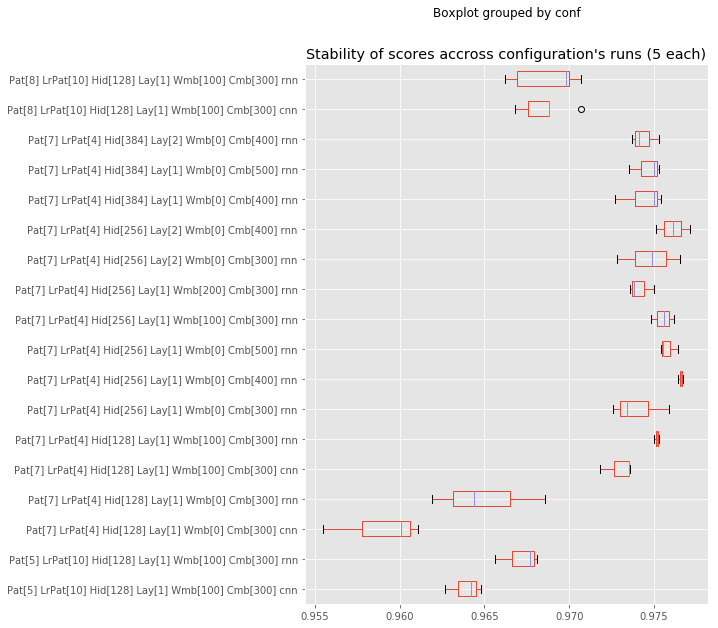

In [39]:
from pandas import DataFrame
import matplotlib.pyplot as plt

def simplify_title(row):
    """Simplify title into a simpler title"""
    # title = row[1]
    # title = title.split("/")[-1].replace(".json", "").replace("1.4.4.a-", "")
    # return [row[0], title] + row[2:]
    return [row[0],Config_Short_Names[row[1]]] + row[2:]
    
models_std = DataFrame(
    [simplify_title(row) for row in table[1:]], 
    columns=table[0]
)
models_std.sort_values(by="conf")
#models_std.groupby("conf").std()#["acc"].plot()

plt.style.use('ggplot')
fig = plt.figure(figsize=(7,10))
ax = fig.gca()
models_std.boxplot(column="acc", by="conf", ax=ax, vert=False)
ax.set_title("Stability of scores accross configuration's runs (5 each)")
ax.set_ylabel("")
ax.set_xlabel("")
fig.show()

# Keeping the best model only

In [40]:
best = {
    
}

from collections import namedtuple

Infos = namedtuple("Infos", ["tar", "acc", "amb", "tok", "train", "nbepoch", "sec_epoch", "sec_words"])
for tar, conf, acc, amb, _, tok, *_, train_time, nb_epochs, sec_epochs, _, words_sec in table[1:]:
    if conf not in best:
        best[conf] = Infos(tar, acc, amb, tok, train_time, nb_epochs, sec_epochs, words_sec)
        continue
    if best[conf].acc < acc:
        best[conf] = Infos(tar, acc, amb, tok, train_time, nb_epochs, sec_epochs, words_sec)
    
column = [
    "file", "conf",
    "acc-all", "acc-amb", "acc-unk-tok",
    "training-time", "nb-epochs", "Sec / Epoch",
    "sec / 1000 words"
]
table2 = []
for conf, values in best.items():
    table2.append([conf, *values])
    
table2 = sorted(table2, key=lambda x: x[2])  # 2 is acc, 3 amb, 4 tokens
table2 = [column] + table2

In [41]:
# Create a table like representation
import tabulate
from IPython.display import HTML, display

display(HTML(tabulate.tabulate(table2, tablefmt='html')))

file,conf,acc-all,acc-amb,acc-unk-tok,training-time,nb-epochs,Sec / Epoch,sec / 1000 words
./configs/1.4.4.a-CNN_vs_RNN-CNN-nowemb.json,./models/cemb_CNN_-wemb_none_-lrpatience_4;7_-lemma-2020_04_24-23_42_23.tar,0.9611,0.9026,0.8003,8025.91,44,182.41,2743.74
./configs/1.4.4.a-CNN_vs_RNN-CNN-patience.json,./models/cemb_CNN_-patience_5_-lemma-2020_04_23-08_27_33.tar,0.9648,0.9127,0.8096,7871.38,41,191.98,2722.2
./configs/1.4.4.a-CNN_vs_RNN-RNN-patience.json,./models/cemb_RNN_-patience_5_-lemma-2020_04_23-06_15_06.tar,0.9681,0.9124,0.837,7185.86,30,239.53,2543.36
./configs/1.4.4.a-CNN_vs_RNN-RNN-nowemb.json,./models/cemb_RNN_-wemb_none_-lrpatience_5;7_-lemma-2020_04_25-05_48_34.tar,0.9686,0.9126,0.836,9665.27,42,230.13,2546.52
./configs/1.4.4.a-CNN_vs_RNN-RNN.json,./models/cemb_RNN_--lemma-2020_04_22-22_48_00.tar,0.9707,0.9171,0.85,0,56,0.0,2534.17
./configs/1.4.4.a-CNN_vs_RNN-CNN.json,./models/cemb_CNN_--lemma-2020_04_22-03_04_02.tar,0.9707,0.9177,0.8562,10065.2,42,239.65,2515.72
./configs/1.4.4.a-CNN_vs_RNN-CNN-lrpatience.json,./models/cemb_CNN_-lrpatience_4;7_-lemma-2020_04_23-23_14_22.tar,0.9736,0.9272,0.8526,13700.8,72,190.29,2733.38
./configs/1.4.4.a-RNN-Wemb_vs_no_wemb-wemb_200-hidden_256.json,./models/cemb_RNN_-wemb_200_min_5_-lrpatience_4_7_-hidden-256-lemma-2020_04_28-00_47_44.tar,0.975,0.9272,0.8704,14947.7,61,245.04,2434.53
./configs/1.4.4.a-RNN-cemb_RNN_-wemb_none_-lrpatience_4_7_-hidden-384-layers_1-cemb_500.json,./models/cemb_RNN_-wemb_none_-lrpatience_4_7_-hidden-384-layers_1-cemb_500-lemma-2020_04_30-06_08_12.tar,0.9753,0.926,0.8729,20209.6,63,320.79,2230.5
./configs/1.4.4.a-RNN-cemb_RNN_-wemb_none_-lrpatience_4_7_-hidden-384-real-layers_2-cemb_400.json,./models/cemb_RNN_-wemb_none_-lrpatience_4_7_-hidden-384-real-layers_2-cemb_400-lemma-2020_05_01-16_15_15.tar,0.9753,0.9261,0.8684,20601.8,71,290.17,2398.39


## Comparing Configurations

In [42]:
import json
from collections import defaultdict

all_keys = defaultdict(set)

def get_values(dic, prefix=None):
    """ This function flattens a dictionary
    """
    if not prefix:
        prefix = []
    if isinstance(dic, list):
        for index, value in enumerate(dic):
            yield from get_values(value, prefix=prefix+[str(index)])
    elif isinstance(dic, dict):
        for key, value in dic.items():
            yield from get_values(value, prefix=prefix+[key])
    else:
        yield ("%".join(prefix), dic)

# Parse all JSON FILES
json_files = []
for config in glob.glob("./configs/*.json"):
    with open(config) as f:
        json_files.append(json.load(f))
        json_files[-1]["config_path"] = config
        
## For each one, add the value to all_keys
for data in json_files:
    for key, value in get_values(data):
        all_keys[key].add(value)


def get_best_score(x):
    if x[0] in best:
        return best[x[0]].acc
    else:
        return None
    

columns = ["config_path"] + [
    key 
    for key, value in all_keys.items()
    if len(value) > 1 and key not in ("modelname", "config_path")
]

title = {
    "patience": "P[{}]",
    "lr_patience": "LP[{}]",
    "hidden_size": "H[{}]",
    "num_layers": "L[{}]",
    "wemb_dim": "W[{}]",
    "cemb_dim": "C[{}]",
    "cemb_type": "{}"
}

def rename(header, row):
    return "".join([
        title[head].format(value)
        for head, value in zip(header, row)
        if r in title
    ])
    
table_models = []
for data in json_files:
    dic = dict(get_values(data))
    table_models.append([
        dic[key]
        for key in columns
    ] + [best[dic["config_path"]].acc])

table_models = sorted(table_models, key=lambda x: x[-1])

display(HTML(tabulate.tabulate([columns+["score"]] + table_models, tablefmt='html')))


print(tabulate.tabulate([
    columns[1:]+["score"]
] + [
    t[1:]
    for t in table_models
], tablefmt='latex'))

config_path,word_max_size,word_min_freq,patience,lr_patience,hidden_size,num_layers,wemb_dim,cemb_dim,cemb_type,score
./configs/1.4.4.a-CNN_vs_RNN-CNN-nowemb.json,20000,1,7,4,128,1,0,300,cnn,0.9611
./configs/1.4.4.a-CNN_vs_RNN-CNN-patience.json,28000,1,5,10,128,1,100,300,cnn,0.9648
./configs/1.4.4.a-CNN_vs_RNN-RNN-patience.json,28000,1,5,10,128,1,100,300,rnn,0.9681
./configs/1.4.4.a-CNN_vs_RNN-RNN-nowemb.json,20000,1,7,4,128,1,0,300,rnn,0.9686
./configs/1.4.4.a-CNN_vs_RNN-RNN.json,28000,1,8,10,128,1,100,300,rnn,0.9707
./configs/1.4.4.a-CNN_vs_RNN-CNN.json,28000,1,8,10,128,1,100,300,cnn,0.9707
./configs/1.4.4.a-CNN_vs_RNN-CNN-lrpatience.json,28000,1,7,4,128,1,100,300,cnn,0.9736
./configs/1.4.4.a-RNN-Wemb_vs_no_wemb-wemb_200-hidden_256.json,20000,5,7,4,256,1,200,300,rnn,0.975
./configs/1.4.4.a-RNN-cemb_RNN_-wemb_none_-lrpatience_4_7_-hidden-384-real-layers_2-cemb_400.json,20000,1,7,4,384,2,0,400,rnn,0.9753
./configs/1.4.4.a-RNN-cemb_RNN_-wemb_none_-lrpatience_4_7_-hidden-384-layers_1-cemb_500.json,20000,1,7,4,384,1,0,500,rnn,0.9753


\begin{tabular}{llllllllll}
\hline
 word\_max\_size & word\_min\_freq & patience & lr\_patience & hidden\_size & num\_layers & wemb\_dim & cemb\_dim & cemb\_type & score  \\
 20000         & 1             & 7        & 4           & 128         & 1          & 0        & 300      & cnn       & 0.9611 \\
 28000         & 1             & 5        & 10          & 128         & 1          & 100      & 300      & cnn       & 0.9648 \\
 28000         & 1             & 5        & 10          & 128         & 1          & 100      & 300      & rnn       & 0.9681 \\
 20000         & 1             & 7        & 4           & 128         & 1          & 0        & 300      & rnn       & 0.9686 \\
 28000         & 1             & 8        & 10          & 128         & 1          & 100      & 300      & rnn       & 0.9707 \\
 28000         & 1             & 8        & 10          & 128         & 1          & 100      & 300      & cnn       & 0.9707 \\
 28000         & 1             & 7        & 4       